### Training Data

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

# Load and preprocess data
def load_data():
    normal_data = pd.read_csv('data/Normal.csv')
    sign1_data = pd.read_csv('data/help_1.csv')
    sign2_data = pd.read_csv('data/help_2.csv')

    # Concatenate all data
    data = pd.concat([normal_data, sign1_data, sign2_data], axis=0)
    
    # Separate features and labels
    X = data.drop(columns='label').values  # Assuming 'label' is the name of the column with labels
    y = data['label'].values

    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    return train_test_split(X, y, test_size=0.2, random_state=42), label_encoder

(X_train, X_test, y_train, y_test), label_encoder = load_data()

# Determine number of features and reshape for LSTM
timesteps = 7  # Choosing 7 timesteps
features = X_train.shape[1] // timesteps  # This results in 9 features per timestep

X_train = np.reshape(X_train, (X_train.shape[0], timesteps, features))
X_test = np.reshape(X_test, (X_test.shape[0], timesteps, features))

In [3]:
# Define and train the LSTM model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(timesteps, features)),
    tf.keras.layers.Dropout(0.5),  # Adding Dropout to reduce overfitting
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes
])

In [4]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 64)             18944     
                                                                 
 dropout_1 (Dropout)         (None, 7, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 32515 (127.01 KB)
Trainable params: 32515 (127.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [3]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

In [4]:
# Train the model
history = model.fit(
    X_train, 
    y_train, 
    epochs=150, 
    validation_split=0.20, 
    callbacks=[early_stopping],
    batch_size=32  # Adjust batch size if needed
)

Epoch 1/150
30/30 [==============================] - 3s 23ms/step - loss: 1.0435 - accuracy: 0.4812 - val_loss: 0.9372 - val_accuracy: 0.5625
Epoch 2/150
30/30 [==============================] - 0s 5ms/step - loss: 0.6617 - accuracy: 0.6323 - val_loss: 0.5383 - val_accuracy: 0.6917
Epoch 3/150
30/30 [==============================] - 0s 5ms/step - loss: 0.5092 - accuracy: 0.6771 - val_loss: 0.5184 - val_accuracy: 0.6333
Epoch 4/150
30/30 [==============================] - 0s 5ms/step - loss: 0.4983 - accuracy: 0.6823 - val_loss: 0.5259 - val_accuracy: 0.6792
Epoch 5/150
30/30 [==============================] - 0s 5ms/step - loss: 0.4906 - accuracy: 0.6885 - val_loss: 0.5724 - val_accuracy: 0.6250
Epoch 6/150
30/30 [==============================] - 0s 5ms/step - loss: 0.4954 - accuracy: 0.7125 - val_loss: 0.5046 - val_accuracy: 0.6750
Epoch 7/150
30/30 [==============================] - 0s 5ms/step - loss: 0.4771 - accuracy: 0.7167 - val_loss: 0.5381 - val_accuracy: 0.6625
Epoch 8/150


### Model Evaluation

In [5]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.4f}')

10/10 [==============================] - 0s 3ms/step - loss: 0.0464 - accuracy: 0.9867
Test accuracy: 0.9867


In [6]:
# Print detailed classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

10/10 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       104
      help_1       0.98      0.98      0.98        86
      help_2       0.98      0.98      0.98       110

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [8]:
# Save the model
model.save('hand_sign_lstm_model_4.h5')

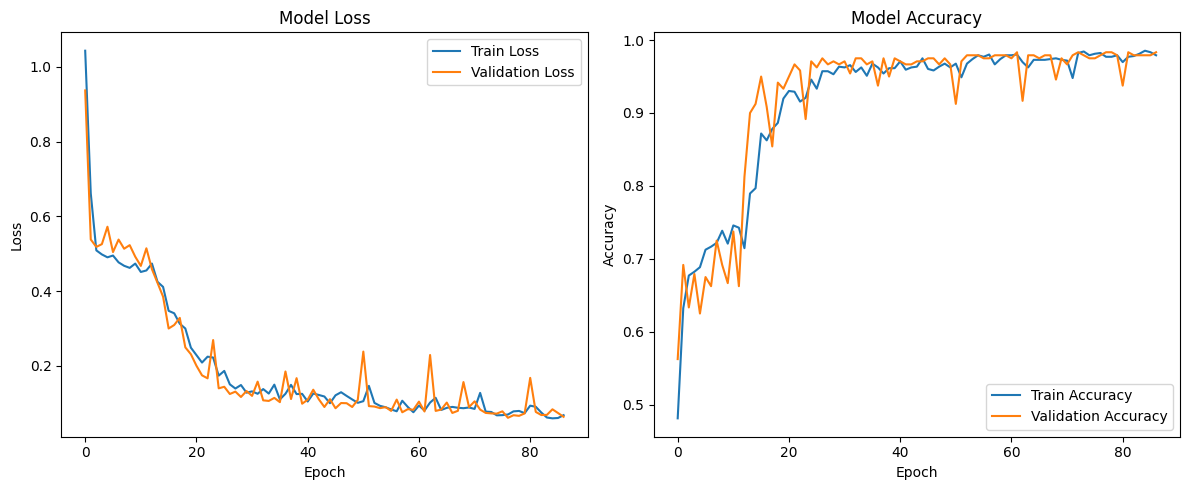

In [9]:
# Plotting the training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

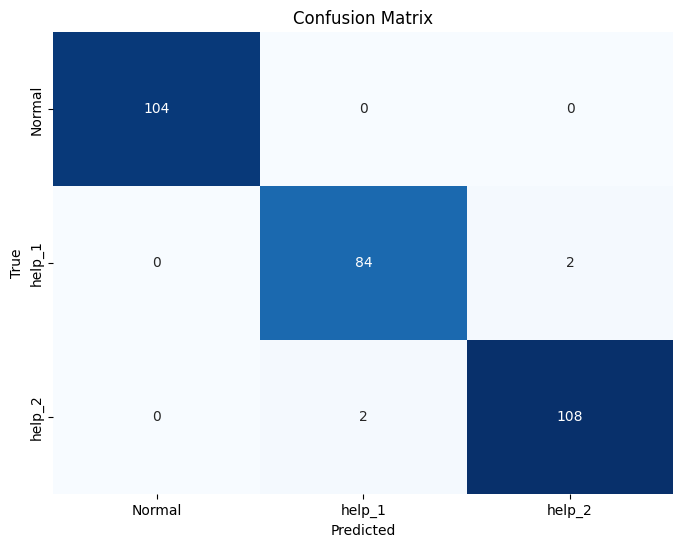

In [10]:
# Generate predictions and confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [11]:
# Calculate and print F1 scores for each class
f1_scores = f1_score(y_test, y_pred_classes, average=None)
for class_name, f1 in zip(label_encoder.classes_, f1_scores):
    print(f'Class: {class_name}, F1 Score: {f1:.2f}')

Class: Normal, F1 Score: 1.00
Class: help_1, F1 Score: 0.98
Class: help_2, F1 Score: 0.98


### Testing Model

In [2]:
import cv2
import time
import mediapipe as mp
import numpy as np
import tensorflow as tf
import pygame

# Initialize pygame mixer
pygame.mixer.init()

# Load the Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the trained model for hand sign detection
try:
    model = tf.keras.models.load_model('hand_sign_lstm_model_5.h5')
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.8)
mp_drawing = mp.solutions.drawing_utils

# Define function to extract hand landmarks
def extract_hand_landmarks(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)
    
    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0]
        landmarks_array = np.array([(lm.x, lm.y, lm.z) for lm in landmarks.landmark]).flatten()
        return landmarks_array, results
    return None, None

# Function to play sound
def play_sound(audio_file):
    try:
        pygame.mixer.music.load(audio_file)
        pygame.mixer.music.play()
    except Exception as e:
        print(f"Error playing sound: {e}")

# Function to stop sound
def stop_sound():
    pygame.mixer.music.stop()

# Initialize box parameters and timing
x, y, w, h = 100, 100, 100, 100  # Default values
detection_interval_1 = 30  # seconds
detection_interval_2 = 40  # seconds

# Main loop to switch between head detection and hand sign detection
while True:
    cap = cv2.VideoCapture(0)

    # Initialize timing
    last_detection_time = time.time()

    def nothing(x):
        pass

    # Create a window
    cv2.namedWindow('Video')

    # Create trackbars for box position and size
    cv2.createTrackbar('X', 'Video', x, 640, nothing)
    cv2.createTrackbar('Y', 'Video', y, 480, nothing)
    cv2.createTrackbar('Width', 'Video', w, 640, nothing)
    cv2.createTrackbar('Height', 'Video', h, 480, nothing)

    head_detected = False
    current_audio_file = None

    # Head detection loop
    while not head_detected:
        ret, frame = cap.read()
        if not ret:
            break

        # Get the positions and sizes from trackbars
        x = cv2.getTrackbarPos('X', 'Video')
        y = cv2.getTrackbarPos('Y', 'Video')
        w = cv2.getTrackbarPos('Width', 'Video')
        h = cv2.getTrackbarPos('Height', 'Video')

        # Draw the rectangle
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        detected = False
        for (fx, fy, fw, fh) in faces:
            if (fx >= x and fy >= y and fx + fw <= x + w and fy + fh <= y + h):
                detected = True
                last_detection_time = time.time()
                break

        # Determine circle colors based on detection time
        elapsed_time = time.time() - last_detection_time

        circle_color_2 = (0, 0, 0)  # Black (default: not visible)
        circle_color_3 = (0, 0, 0)  # Black (default: not visible)

        if elapsed_time > detection_interval_2:
            circle_color_3 = (0, 0, 255)  # Red
            if current_audio_file != 'alert-33762.mp3':
                stop_sound()
                play_sound('alert-33762.mp3')
                current_audio_file = 'alert-33762.mp3'
        elif elapsed_time > detection_interval_1:
            circle_color_2 = (0, 255, 255)  # Yellow
            if current_audio_file != 'weeb-alert-182941.mp3':
                stop_sound()
                play_sound('weeb-alert-182941.mp3')
                current_audio_file = 'weeb-alert-182941.mp3'
        else:
            if current_audio_file is not None:
                stop_sound()
                current_audio_file = None

        # Draw circles
        cv2.circle(frame, (100, 50), 20, circle_color_2, -1)
        cv2.circle(frame, (200, 50), 20, circle_color_3, -1)

        # Display text based on detection
        if detected:
            cv2.putText(frame, "Yes", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            head_detected = True
            stop_sound()  # Stop sound when head is detected
        else:
            cv2.putText(frame, "No", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

        # Display elapsed time
        time_text = f"Time: {int(elapsed_time)}s"
        cv2.putText(frame, time_text, (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)

        # Display the frame
        cv2.imshow('Video', frame)

        # Break loop on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            exit()

    cap.release()
    cv2.destroyAllWindows()

    if head_detected:
        cap = cv2.VideoCapture(0)
        last_label = None
        current_audio_file = None
        last_hand_detection_time = time.time()
        hand_detection_timeout = 10  # seconds

        while True:
            success, image = cap.read()
            if not success:
                break
            
            landmarks, results = extract_hand_landmarks(image)
            if landmarks is not None:
                last_hand_detection_time = time.time()

                # Reshape landmarks to (7, 9) and add batch dimension
                landmarks_array = landmarks.reshape(7, 9)
                landmarks_array = np.expand_dims(landmarks_array, axis=0)

                prediction = model.predict(landmarks_array)
                class_id = np.argmax(prediction)
                
                # Determine the label based on the class_id
                if class_id == 0:
                    label = 'Normal'
                    audio_file = None  # No sound for 'Normal'
                elif class_id == 1:
                    label = 'Sign 1'
                    audio_file = 'weeb-alert-182941.mp3'
                elif class_id == 2:
                    label = 'Sign 2'
                    audio_file = 'alert-33762.mp3'
                
                # Draw hand landmarks on the image
                if results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(image, results.multi_hand_landmarks[0], mp_hands.HAND_CONNECTIONS)
                
                # Display the detected sign and confidence score on the image
                cv2.putText(image, f"Detected: {label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                confidence = np.max(prediction)
                cv2.putText(image, f'Confidence: {confidence:.2f}', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2, cv2.LINE_AA)

                # Play the corresponding MP3 file if the sign is different from the last one announced
                if label != last_label or audio_file != current_audio_file:
                    if audio_file is not None:
                        stop_sound()  # Stop any currently playing audio
                        play_sound(audio_file)
                    elif label == 'Normal':
                        stop_sound()  # Stop any currently playing audio if 'Normal' is detected
                    last_label = label
                    current_audio_file = audio_file
            else:
                # No landmarks detected, stop the sound if it was playing
                if last_label is not None:
                    stop_sound()  # Stop any currently playing audio
                    last_label = None
                    current_audio_file = None

            # Check for hand detection timeout
            if time.time() - last_hand_detection_time > hand_detection_timeout:
                head_detected = False
                break

            cv2.imshow('Hand Sign Detection', image)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
        cap.release()
        cv2.destroyAllWindows()
        
if cv2.waitKey(2) & 0xFF == ord('e'):
    cap.release()
    cv2.destroyAllWindows()
    break  


Model loaded successfully.
1/1 [==============================] - 0s 15ms/step


KeyboardInterrupt: 